# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np
import speckleret as spr

Load the interferometric data

NF shape: (1, 600, 600), FF shape = (1, 800, 800)


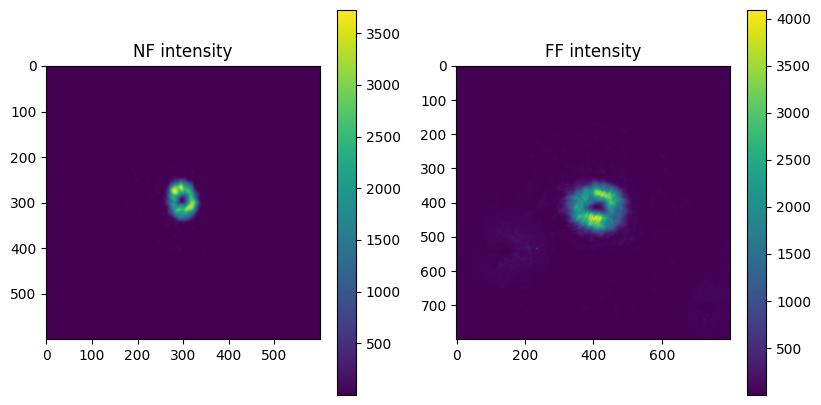

In [25]:
# path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\Outs'
# cmd_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\cmds\Phase_only_Holos'
# sav_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\pr_results'

# path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\Outs\Outs of clx holos\new ouverture'
# cmd_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\cmds\Clx holos'
# sav_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\pr_results_cplx\new_ouverture'

path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\Outs\oams\with and without wreap with  2 filter positions'
cmd_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\cmds\Clx holos'
sav_path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\PR_FIber_ins\Data\pr_results_20250923'


expl_number = ''
phi_dim = 16
name = 'oam_sim'
suffix = ''

# data_CP = f'{phi_dim}_{phi_dim}_NF_{expl_number}_clx_t.npz'
# data_CL = f'{phi_dim}_{phi_dim}_FF_{expl_number}_clx_t.npz'
# data_phi = f'holo_Acuators_{phi_dim}_{expl_number}_clx.npz'

data_CP = f'{name}_{phi_dim}_nf_t.npz'
data_CL = f'{name}_{phi_dim}_ff_t.npz'

# 4_4_ff_prewrap_t

# data_CP = f'{name}{phi_dim}{phi_dim}_nf_{suffix}_{expl_number}t.npz'
# data_CL = f'{name}{phi_dim}{phi_dim}_ff_{suffix}_{expl_number}t.npz'
# data_phi = f'{phi_dim}_{phi_dim}_{suffix}_cmd.npz'

# data_CP = f'top_hat_nf_t.npz'
# data_CL = f'top_hat_ff_t.npz'
data_phi = f'oam_{phi_dim}.npz'

CP = np.load(os.path.join(path, data_CP))['original'][:, :]
CL = np.roll(np.load(os.path.join(path, data_CL))['original'], axis=(0, 1), shift=(-0, 0))[:, :]

savename = os.path.splitext(data_CP)[0]

try:
    phi = np.load(os.path.join(cmd_path, data_phi))
    phi = phi[list(phi.keys())[0]]
except FileNotFoundError:
    phi = None
    
# phi = None



CP = np.reshape(CP, shape=(1, *CP.shape))
CL = np.reshape(CL, shape=(1, *CL.shape))

print(f"NF shape: {CP.shape}, FF shape = {CL.shape}")


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(CP[0, ...])
plt.title("NF intensity")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(CL[0, ...])
plt.title("FF intensity")
plt.colorbar()

if phi is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(complex_to_hsv(phi, 0.0, 1))
    plt.title("Command")

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

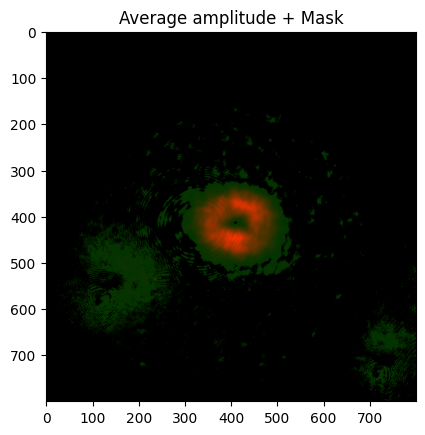

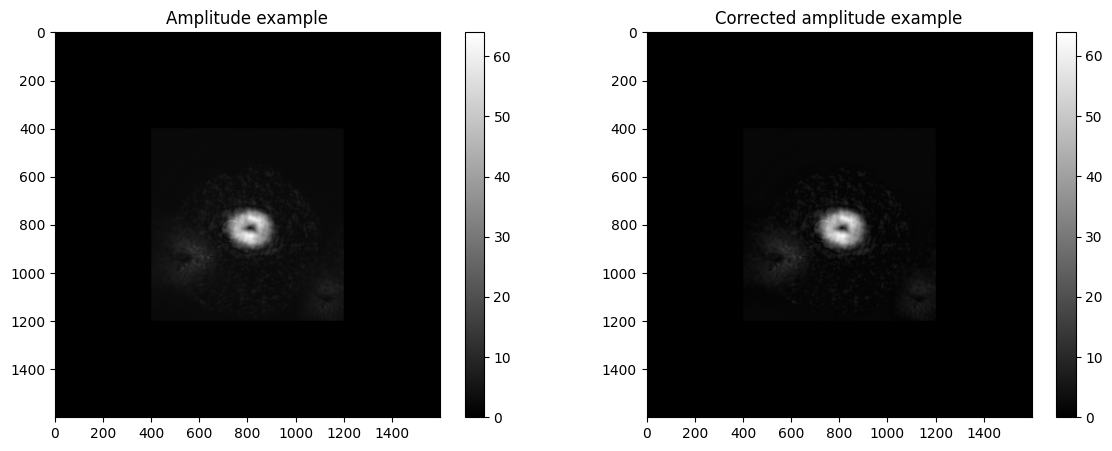

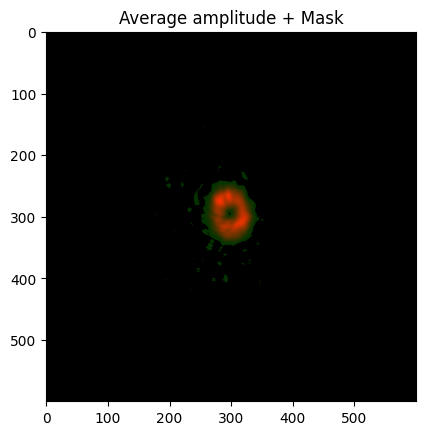

10.93668125


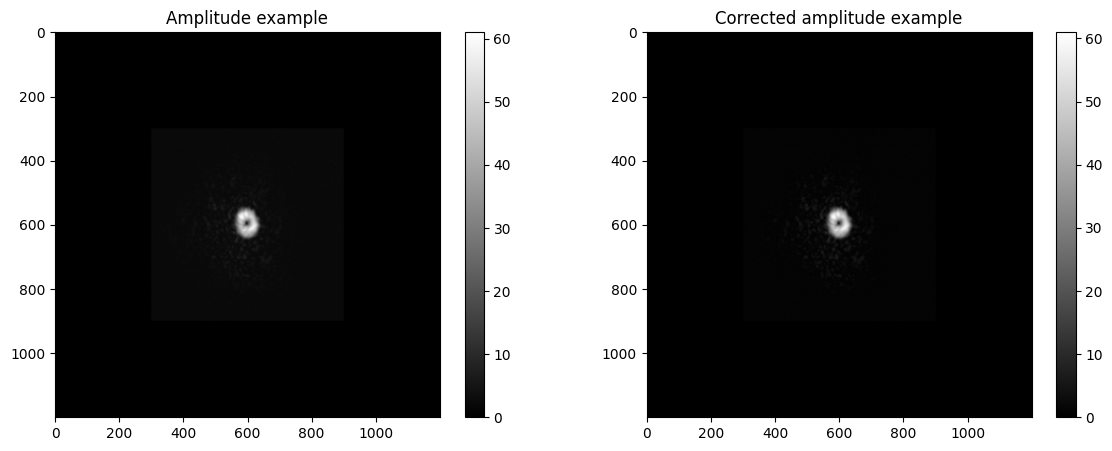

In [26]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.01, plot_result=True, plot_mask=True)
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0), mask_trsh=0.01, plot_mask=True, plot_result=True)

print(noise_corr)

Let's detect the average centroids

In [27]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(0, 2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(0, 2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (np.float64(299.01461102726114), np.float64(297.38082710292394))
Average centroid CL: (np.float64(429.67862834307874), np.float64(395.926478392919))


### Data preparation

Select data for phase retrieval

1238
(1238, 1238) 2421038.8840975114
(1238, 1238) 2421038.8840975114
(1238, 1238) 10813268.007048802


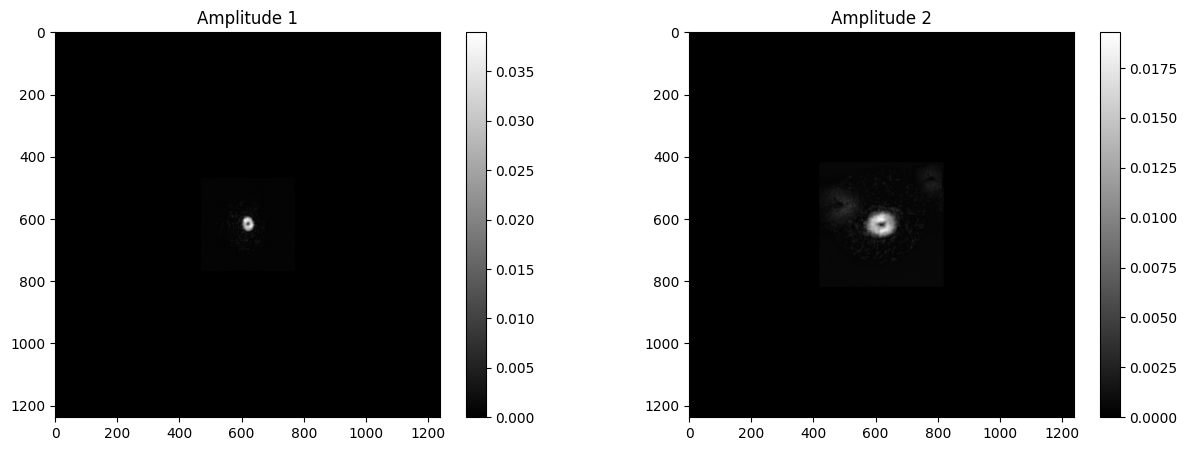

In [28]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 2
bin_cl = 2
wavelength = 561.4e-9
focal_length = 105e-3
N_window = compute_N_win(wavelength, focal_length, bin_cp * 3.45e-6, bin_cl * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = np.roll(field, shift=-CP_shift, axis=(0,1))

field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int)
# ft = np.roll(ft, shift=-5*CL_shift, axis=(0,1))
ft = np.roll(ft, shift=(-15, -12), axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

if field.shape[0] < N_window:
    field = np.pad(field, [0, N_window - field.shape[0]])
if ft.shape[0] < N_window:
    ft = np.pad(ft, [0, N_window - ft.shape[0]])

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)

print(field.shape, field_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

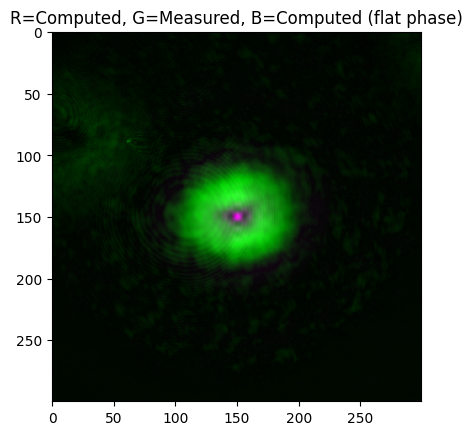

In [29]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = f_pad

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

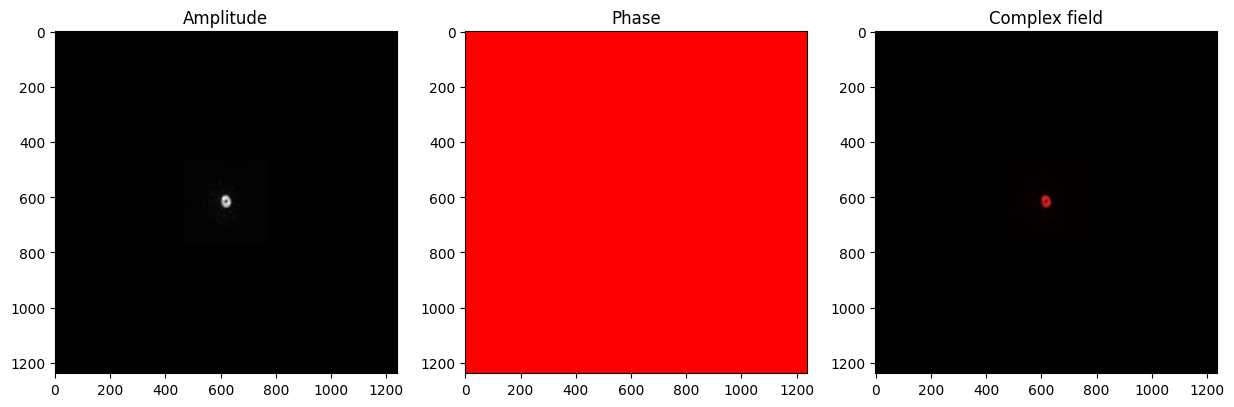

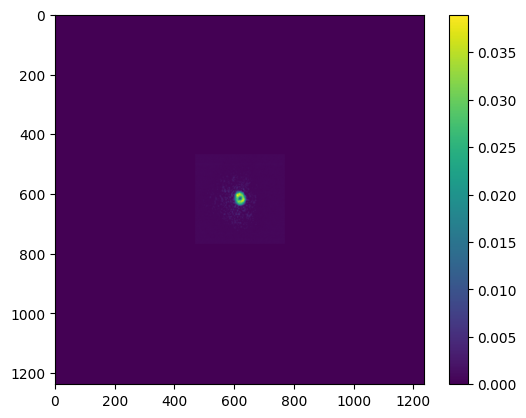

In [30]:
import speckleret.torch as tspr
import torch

tfield = torch.from_numpy(field).to(torch.float)
tfield = tfield.unsqueeze(0).unsqueeze(0)

support = tspr.supports.threshold_support(tfield, threshold=0.00)
# support = tspr.supports.disk_support(tfield, radius=100, offsets=(0,0))
supported_field = tspr.transforms.apply_support(tfield, support)
_ = spr.plots.complex_imshow(supported_field.cpu().detach().numpy().squeeze())

plt.figure()
plt.imshow(supported_field.cpu().detach().numpy().squeeze())
plt.colorbar()

In [13]:
from waveoptics.plots.plots import complex_to_hsv


def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = torch.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

Total time: 1.1683 seconds


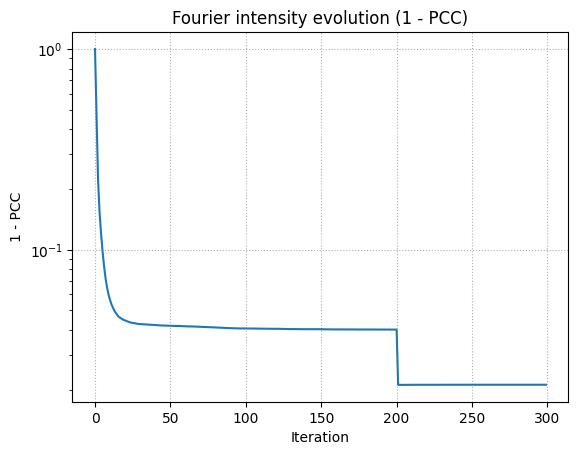

In [40]:
import torch.optim as optim
from lion_pytorch import Lion

tft = torch.from_numpy(ft).to(torch.float)
tft = tft.unsqueeze(0).unsqueeze(0)


device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)



if device.startswith("cuda"):
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        # magnitudes=(torch.abs(tft), torch.abs(tfield)),
        support=support,
        # init=x,
        # init=tspr.initializers.gradient_descent(
        #         magnitude_near_field=torch.abs(tfield),
        #         magnitude_far_field=torch.abs(tft),
        #         support=support,
        #         optimizer_class=torch.optim.AdamW,
        #         optimizer_kwargs=dict(lr=1e-0),
        #         max_iter=200,
        # ),
        # init=tspr.initializers.spectral(torch.abs(tft)),
        # init=tspr.initializers.gao_xu(torch.abs(tfield)),
        # init=tspr.initializers.flat_phases(torch.abs(tfield)),
        init=tspr.initializers.random_phases(torch.abs(tfield)),
        algorithm=tspr.retrieval.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=200,
)
results.append(result)


x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        # magnitudes=(torch.abs(tft), torch.abs(tfield)),
        support=support,
        init=x,
        # init=tspr.initializers.spectral(torch.abs(tft)),
        # init = tspr.initializers.spectral(torch.abs(tft)),
        # init=tspr.initializers.gradient_descent(
        #         magnitude_near_field=torch.abs(tfield),
        #         magnitude_far_field=torch.abs(tft),
        #         support=support,
        #         optimizer_class=torch.optim.AdamW,
        #         optimizer_kwargs=dict(lr=1e-0),
        #         max_iter=200,
        # ),
        # init=tspr.initializers.flat_phases(torch.abs(tfield)),
        # init=tspr.initializers.random_phases(torch.abs(tfield)),
        algorithm=tspr.retrieval.ER,
        # algorithm_kwargs={'beta': 0.99},
        max_iter=100,
)
results.append(result)


# x, gd_losses = tspr.initializers.gradient_descent(
#         magnitude_near_field=torch.abs(tfield),
#         magnitude_far_field=torch.abs(tft),
#         support=support,
#         cyclic_loss=True,
#         optimizer_class=torch.optim.Adam,
#         # optimizer_class=Lion,
#         optimizer_kwargs=dict(lr=1e-0),
#         max_iter=200,
#         return_loss=True,
# )
# plt.plot(gd_losses)
# plt.yscale('log')
# plt.show()

end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Total time: {elapsed_time_ms/1000:.4f} seconds")



tspr.retrieval.report_convergence_results(merge_dicts(results), key='pearson_fourier')



x_hat = x
# x_hat = torch.abs(supported_field) * torch.exp(1j * torch.angle(x))
y_hat = tspr.transforms.fourier_transform(x_hat)

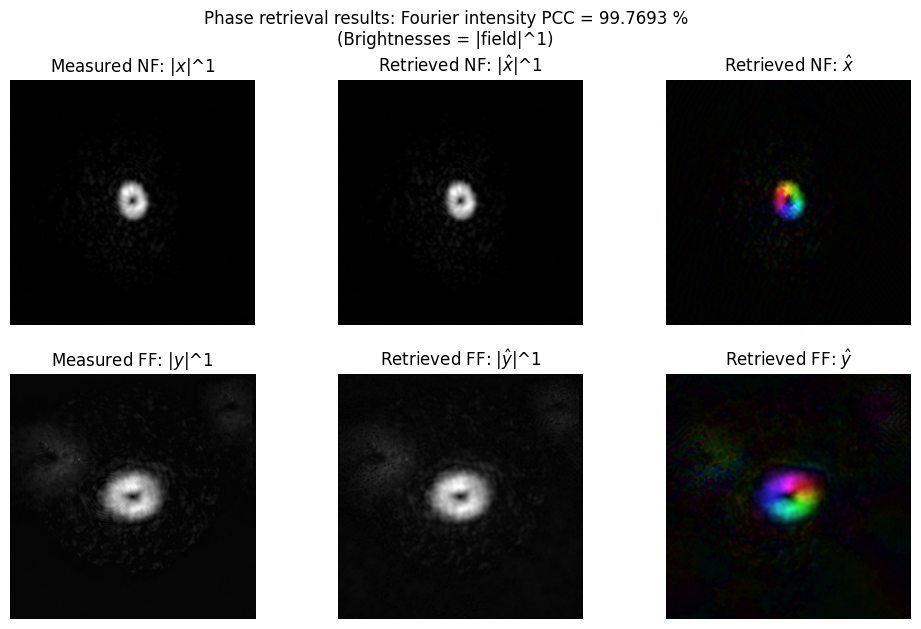

In [41]:
from waveoptics.plots.plots import complex_imshow

hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=1,
    window_crop=f_pad,
    window_crop_ff=ft_pad,
)

if phi is not None:
    plt.figure()
    complex_imshow(phi)
# plt.imshow(complex_to_hsv(phi, 0, 1))

In [1]:
from scipy.optimize import curve_fit

win = f_pad
xx = x_hat.cpu().detach().squeeze().numpy()
xx = xx[win:-win, win:-win]

# support_xx = spr.supports.disk_support(xx, radius=40, offsets=(0, 0)) #* spr.supports.threshold_support(xx, threshold=0.002)
support_xx = spr.supports.threshold_support(xx, threshold=0.01)
# support_xx = 
# support_xx
supported_xx = xx.copy()
supported_xx[np.logical_not(support_xx)] = np.nan
# _ = spr.plots.complex_imshow(supported_xx)

def func_lin(x, a, b, c):
    return a * x[0] + b * x[1] + c

x_grid = np.arange(0, xx.shape[0])
y_grid = np.arange(0, xx.shape[1])
X, Y = np.meshgrid(x_grid, y_grid)
X_supp, Y_supp = X[support_xx], Y[support_xx]
diff = np.angle(supported_xx)

x_fit_data = np.vstack((X_supp.reshape((1, X_supp.size)), Y_supp.reshape((1, Y_supp.size))))
y_fit_data = diff[~np.isnan(diff)] - 1
print(x_fit_data.shape, y_fit_data.shape)

# Curve fit
popt, pcov = curve_fit(func_lin, x_fit_data, y_fit_data, method='lm')
print("fitted: {}".format(popt))
z_fit = func_lin(x_fit_data, *popt)


diff_corr = np.zeros_like(diff) * np.nan
fitted = np.zeros_like(diff) * np.nan
diff_corr[support_xx] = np.angle(np.exp(1j * (diff[support_xx] - z_fit)))
fitted[support_xx] = np.angle(np.exp(1j * z_fit))

xx_corr = np.zeros_like(xx)
xx_corr[support_xx] = np.abs(xx[support_xx]) * np.exp(-1j * diff_corr[support_xx])

print(f"Std: {np.nanstd(diff_corr)} rad")
print(f"Lambda / X rms: {2 * np.pi / np.nanstd(diff_corr):3.1f} rms")



plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(np.abs(supported_xx), cmap='gray')
plt.title("Amplitude of the field to correct")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 4, 2)
plt.imshow(diff, cmap='hsv')
plt.title("Phase to correct")
plt.colorbar(orientation='horizontal')
plt.clim([-np.pi, +np.pi])

plt.subplot(1, 4, 3)
plt.imshow(diff_corr, cmap='hsv')
plt.title("Corrected phase (after slope fit removal)")
plt.colorbar(orientation='horizontal')
plt.clim([-np.pi, +np.pi])

plt.subplot(1, 4, 4)
plt.imshow(fitted, cmap='hsv', vmin=-np.pi, vmax=-np.pi)
plt.title("Fitted phase")
plt.clim([-np.pi, +np.pi])
plt.colorbar(orientation='horizontal')




plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
xx = xx * np.exp(-1j * np.angle(xx[75, 75]))
xx_corr = xx_corr * np.exp(-1j * np.angle(xx_corr[75, 75]))
plt.imshow(spr.plots.complex_to_hsv(np.squeeze(xx), 0, np.max(np.abs(xx))))

plt.subplot(1, 3, 2)
plt.imshow(spr.plots.complex_to_hsv(np.squeeze(xx_corr), 0, np.max(np.abs(xx_corr))))

if phi is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(spr.plots.complex_to_hsv(np.squeeze(phi), 0, np.max(np.abs(phi))))

NameError: name 'f_pad' is not defined

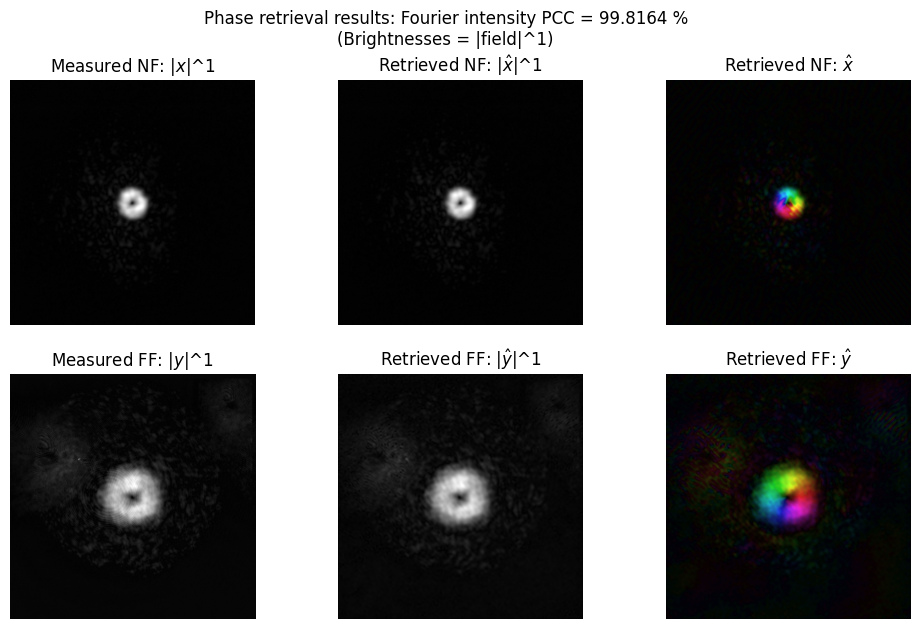

In [180]:
hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=1,
    window_crop=f_pad,
    window_crop_ff=ft_pad,
)
plt.savefig(os.path.join(sav_path, f'pr_result_plot_{savename}.svg'))
plt.savefig(os.path.join(sav_path, f'pr_result_plot_{savename}.png'))





# plt.figure()
# plt.imshow(spr.plots.complex_to_hsv(np.squeeze(phi), 0, 1))

# plt.savefig(os.path.join(sav_path, f'pr_command_{phi_dim}_{phi_dim}_{expl_number}.svg'))
# plt.savefig(os.path.join(sav_path, f'pr_command_{phi_dim}_{phi_dim}_{expl_number}.png'))

C:\Users\saucourt\AppData\Local\Temp\ipykernel_10572\4167576864.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
C:\Users\saucourt\AppData\Local\Temp\ipykernel_10572\4167576864.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)


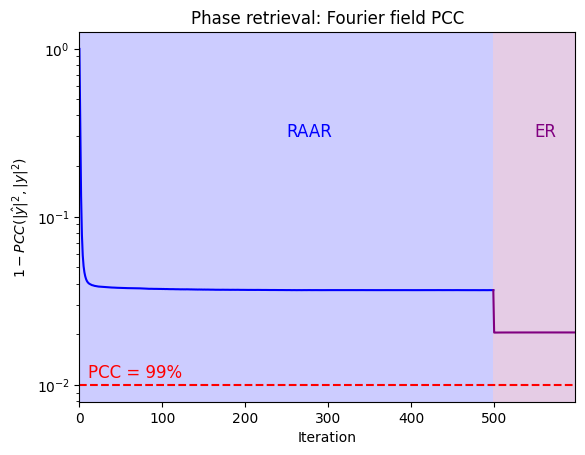

In [181]:
key = 'pearson_fourier'


p1 = results[0][key].cpu()
t1 = torch.arange(0, len(p1))
p2 = results[1][key].cpu()
t2 = torch.arange(len(p1) -1 , len(p1) + len(p2)  -1)

plt.plot(t1, torch.squeeze(p1), label='Algorithm = RAAR', color='blue')
plt.plot(t2, torch.squeeze(p2), label='Algorithm = ER', color='purple')
plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)
plt.axhline(1e-2, color='r', ls='--')
plt.text(10, 1.1e-2, 'PCC = 99%', fontsize=12, color='red')
plt.text(max(t1) // 2, 3e-1, 'RAAR', fontsize=12, color='blue')
plt.text(max(t1) + (max(t2) - max(t1)) // 2, 3e-1, 'ER', fontsize=12, color='purple')

plt.xlim([0, len(p1) + len(p2)-2])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$1 - PCC(|\hat{y}|^2, |y|^2)$')
# plt.legend()
plt.title('Phase retrieval: Fourier field PCC')




np.savez(
    file=os.path.join(sav_path, f'pr_result_data_{savename}.npz'),
    field=tfield.cpu().numpy(),
    fourier=tft.cpu().numpy(),
    retrieved_field=x_hat.cpu().numpy(),
    retrieved_fourier=y_hat.cpu().numpy(),
    pr_results=results,
    bin_cp=bin_cp,
    bin_cl=bin_cl,
    N_window=N_window,
    focal_length=focal_length,
    wavelength=wavelength,
)



plt.savefig(os.path.join(sav_path, f'pr_converg_{savename}.svg'))
plt.savefig(os.path.join(sav_path, f'pr_converg_{savename}.png'))
